# GEM Built-up areas use-case

<img src="./figs/built-up_demo.png">

This notebook contains information about, and code to access the following data:
   * [Google open buildings raster data over Africa](#google)
   * [Results of LightGBM regression built-up model](#lgbm_r)
   * [Results of LightGBM categorical built-up model](#lgbm_c)
   * [Results of TFCN regression and classification built-up models](#tfcn)

The results can be explored also on [GEM web page](https://www.globalearthmonitor.eu/sites/default/files/D5.2_demo.html).

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import FeatureType
from eolearn.io import SentinelHubInputTask
from sentinelhub import CRS, Band, BBox, DataCollection, Unit

### BYOC collection for GEM built-up use-case

The following code snippet sets up the BYOC collection object, to be used with [sentinelhub-py](http://sentinelhub-py.readthedocs.io/), [eo-learn](http://eo-learn.readthedocs.io) and [eo-grow](http://eo-grow.readthedocs.io/) -- the three cornerstones of GEM processing framework.

In [2]:
band_names = ["google", "lgbm_rmse", "lgbm_cat", "tfcn_r", "tfcn_rc", "tfcn_2out_r", "tfcn_2out_c"]

built_up_collection = DataCollection.define_byoc(
    "6701abce-6aff-448a-b149-ab285620f135",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

<a id='google'></a>
## Rasterised "Open buildings" dataset by Google

The Open buildings dataset of building footprints has been released by Google to support social good applications. Building footprints are useful for a range of important applications, ranging from population estimation, urban planning, and humanitarian response to environmental and climate sciences. This large-scale open dataset contains the outlines of buildings derived from high-resolution satellite imagery.

<img src="./figs/open_buildings_africa.png" width="400 px"/>

*Google Open Buildings dataset over Africa. The image shows number of buildings per EOPatch.*

Regardless of the issues of the dataset (e.g., both the labels for the training and the prediction itself were done on Maxar 50cm imagery, but the information about the observation date is not given, poor performance on very dense areas, bad footprints as they probably come from different timestamps than the underlying imagery, spurious activations, missed very large buildings. See also [this GEM blog post](https://medium.com/sentinel-hub/challenges-of-large-open-source-datasets-for-building-detection-in-africa-4d1376f85894)), we have rasterised the dataset to the resolution of the 120m Sentinel-2 mosaic, assigning each pixel the fraction of area covered with buildings.

The resulting raster dataset is used as training data for the regression model - assigning each pixel a fraction covered by built-up areas.

In the following eo-learn example, we will retrieve the data over Dakar area.

In [3]:
google_buildings_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "google_buildings"),
    data_collection=built_up_collection,
    bands=["google"],
    resolution=120,
    max_threads=3,
)

In [5]:
dakar_bbox = BBox((223000, 1604000, 305000, 1652000), CRS.UTM_28N)

In [6]:
eopatch = google_buildings_download_task.execute(bbox=dakar_bbox, time_interval=["2020-01-01", "2021-01-01"])

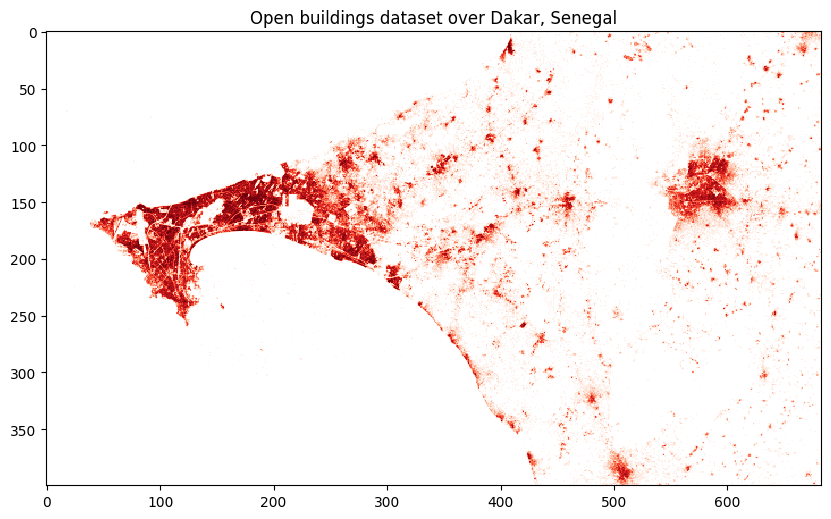

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(
    np.ma.masked_where(
        eopatch.data["google_buildings"].squeeze(axis=(0, -1)) == 0,
        eopatch.data["google_buildings"].squeeze(axis=(0, -1)),
    ),
    interpolation="nearest",
    cmap=plt.cm.Reds,
)
ax.set_title("Open buildings dataset over Dakar, Senegal");

<a id='lgbm_r'></a>
## Results of LightGBM regression built-up model

For the buildt-up use case in Africa we used 120 m Sentinel-2 global mosaic for 2020, see [GEM ML datacubes](./gem-ML-datacubes.ipynb) notebooks for details how to access the data. 

For reference data we used open buildings dataset from previous section. The reference data is highly unbalanced with less than 0.4% of pixels, which consist of at least 20% built-up area. Due to the unbalanced data we have tried various approaches between random (flat) sampling and balanced sampling, based on grouping the pixels into 5 bins according to the amount of built-up area a pixel contains. 

The [LightGBM](https://lightgbm.readthedocs.io/) regression model, where prediction for each pixel carries information of fractional cover - ratio of pixel area with built-up (artificial) surfaces, can be accessed in very similar manner than before:

In [14]:
regression_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "lgbm_regression"),
    data_collection=built_up_collection,
    bands=["lgbm_rmse"],
    resolution=120,
    max_threads=3,
)

In [15]:
eopatch = regression_download_task.execute(eopatch)

In [16]:
eopatch

EOPatch(
  data={
    google_buildings: numpy.ndarray(shape=(1, 400, 683, 1), dtype=float32)
    lgbm_regression: numpy.ndarray(shape=(1, 400, 683, 1), dtype=float32)
  }
  bbox=BBox(((223000.0, 1604000.0), (305000.0, 1652000.0)), crs=CRS('32628'))
  timestamps=[datetime.datetime(2020, 12, 31, 0, 0)]
)

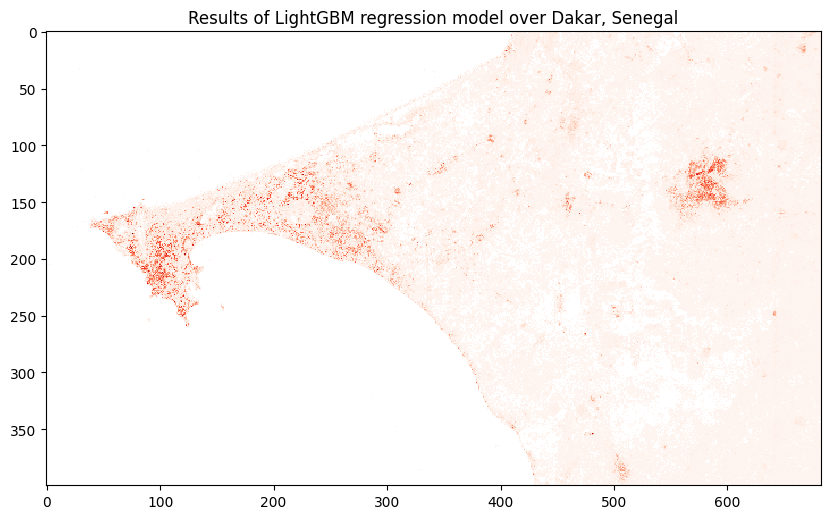

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(
    np.ma.masked_where(
        eopatch.data["lgbm_regression"].squeeze(axis=(0, -1)) < 1e-3,
        eopatch.data["lgbm_regression"].squeeze(axis=(0, -1)),
    ),
    interpolation="nearest",
    cmap=plt.cm.Reds,
)
ax.set_title("Results of LightGBM regression model over Dakar, Senegal");

<a id="lgbm_c"></a>
## Results of LightGBM categorical built-up model

Fractional cover map, retrieved in section above, is very useful, but sometimes knowing "is there some built-up area in this pixel" is the question at hand. In such case, one can of course use fractional cover map, and threshold it, like so:

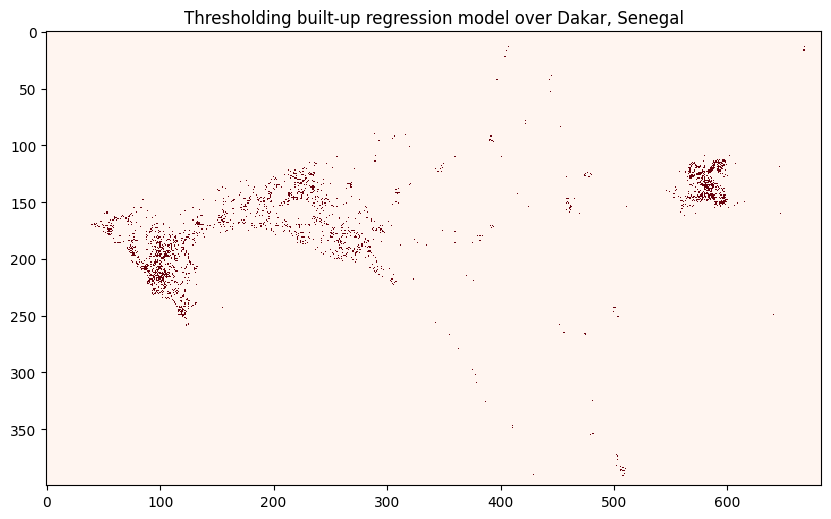

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(eopatch.data["lgbm_regression"].squeeze(axis=(0, -1)) > 0.1, interpolation="nearest", cmap=plt.cm.Reds)
ax.set_title("Thresholding built-up regression model over Dakar, Senegal");

Unfortunately, that approach might not provide best results, since the model was trained for regression task, and it is not sure what the optimal threshold would be. So we have trained another model, LightGBM classifier, to predict if the pixel has built-up surfaces (training on pixels where there with any built-up cover). In the dataset, we include the pseudo-probabilities of each pixel belonging to built-up class. 

The pseudoprobabilities can be obtained using the following task:

In [37]:
classification_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "lgbm_classification"),
    data_collection=built_up_collection,
    bands=["lgbm_cat"],
    resolution=120,
    max_threads=3,
)

In [24]:
eopatch = classification_download_task.execute(eopatch)

Looking at the histogram of the retrieved data, we see that the model is really not very confident, which is not really surprising, as it is based on the very unbalanced data. 

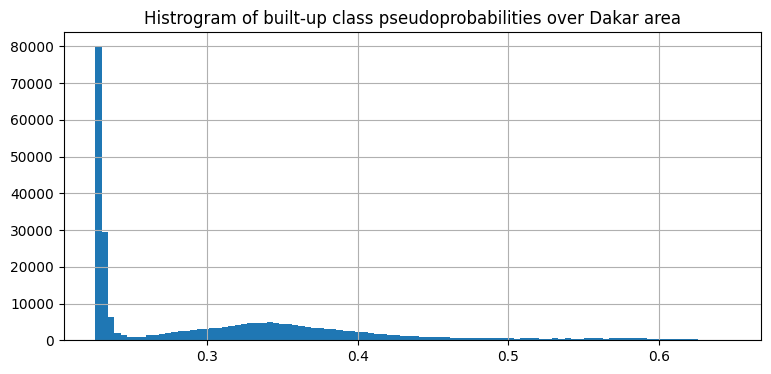

In [42]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(eopatch.data["lgbm_classification"].ravel(), bins=100)
ax.grid("on")
ax.set_title("Histrogram of built-up class pseudoprobabilities over Dakar area");

Regardless, threshold the pseudoprobabilities, we can get a nice map of built-up areas at 120m resolution:

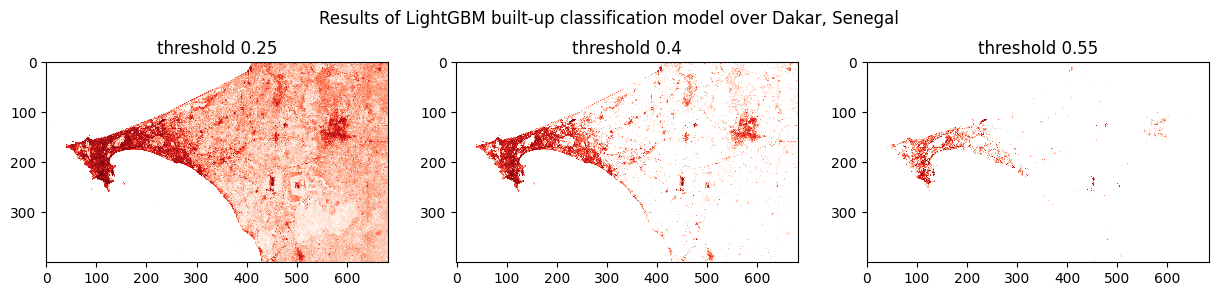

In [54]:
thresholds = [0.25, 0.4, 0.55]
fig, axes = plt.subplots(figsize=(len(thresholds) * 5, 5), ncols=len(thresholds))
for ax, threshold in zip(axes.flatten(), thresholds):
    ax.imshow(
        np.ma.masked_where(
            eopatch.data["lgbm_classification"].squeeze(axis=(0, -1)) < threshold,
            eopatch.data["lgbm_classification"].squeeze(axis=(0, -1)),
        ),
        interpolation="nearest",
        cmap=plt.cm.Reds,
    )
    ax.set_title(f"threshold {threshold}")
fig.suptitle("Results of LightGBM built-up classification model over Dakar, Senegal", y=0.8);

<a id="tfcn"></a>
## Results of TFCN regression and classification built-up models

The experiments above reported were executed using a pixel-wise ML model, meaning that a built-up fraction value was estimated for each pixel separately and independently, depending only on the reflectance values of the pixel. While such approach has the advantage of being flexible and fast to train and run inference on, it fails to capture the contextual information provided by the neighbourhood of each analysed pixel. As the built-up areas exhibit specific contextual patterns, we evaluated the performance of Convolutional Neuronal Networks (CNNs) on the task at hand. CNNs have become the state-of-the-art methods in computer vision for the semantic understanding of natural and remote sensing images.

In particular, we considered the Temporal Fully Convolutional Network (TFCN) architecture.

For training, we have split the rasterised "Open buildings" dataset from EOPatch grid over Africa into train, test and cross-validation datasets, as can be seen in the image below:

<img src="./figs/tfcn_sampling.png" width="400 px" />

_Train (green), cross-validation (blue) and test (red) samples._

#### TFCN architecture

The TFCN architecture is based on a Fully Convolutional Network (FCN), also known as U-net. The FCN architecture is de facto state-of-the-art architecture in semantic segmentation of natural and remotely sensed images. While the backbone of the FCN consisting of an encoding and decoding part are maintained, the convolutions in the encoding path of the TFCN are 3D rather than 2D. This modification allows the network to learn spatial-temporal features simultaneously, therefore characterising built-up areas both in the spatial and temporal dimension.

<img src="./figs/tfcn_architecture.png" width="600 px" />

In practice, the TFCN works with time-series of input shape `[M, T, H, W, D]`, where `M` is the mini-batch size, `T` is the number of acquisitions through time, and `H`, `W` and `D` are the height, width, and number of bands (i.e., depth) of the input image tensor. At the bottom of the TFCN and along the skip connections, a 1D convolution along the temporal dimension is performed to linearly combine the temporal features. The resulting tensors are 4D of shape `[M, H, W, 1]`, estimating the fraction of built-up for each pixel in the input time-series.

Code for the TFCN architecture is open-source and can be found in [sentinel-hub/eo-flow](https://github.com/sentinel-hub/eo-flow/).

Similarly as with LGBM, we have trained several models to see which performs best:

 * TFCN regression, where each pixel estimates the fraction of built-up area
 * TFCN classification, where each pixel is classified as built-up or not
 
In addition, we have experimented with different loss functions, specifically to include both regression and classification task simultaniously during optimisation of the model. This was done in two different ways:

 * A) by using a single output and two losses, a Mean Squared Error (MSE) loss for the regression task and a Binary Cross Entropy (BCE) loss for the classification task. The two losses are then combined in a weighted sum to ensure they equally contribute to the total loss.
 * B) by using two separate outputs and applying a MSE loss on one output and a BCE loss on the other. The difference in this case is that the two separate outputs are allowed to vary independently, focusing on the different tasks.

#### Results

Here, we will have a look at the results of TFCN regression, for 
 * model using only regression results to calculate loss: `tfcn_r`
 * model using both regression and classification to calculate (joint) loss: `tfcn_rc`
 * model using two separate outputs and applying single loss to each: `tfcn_2out_r`

In [58]:
tfcn_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "tfcn"),
    data_collection=built_up_collection,
    bands=["tfcn_r", "tfcn_rc", "tfcn_2out_r"],
    resolution=120,
    max_threads=3,
)

In [57]:
eopatch = tfcn_download_task.execute(eopatch)

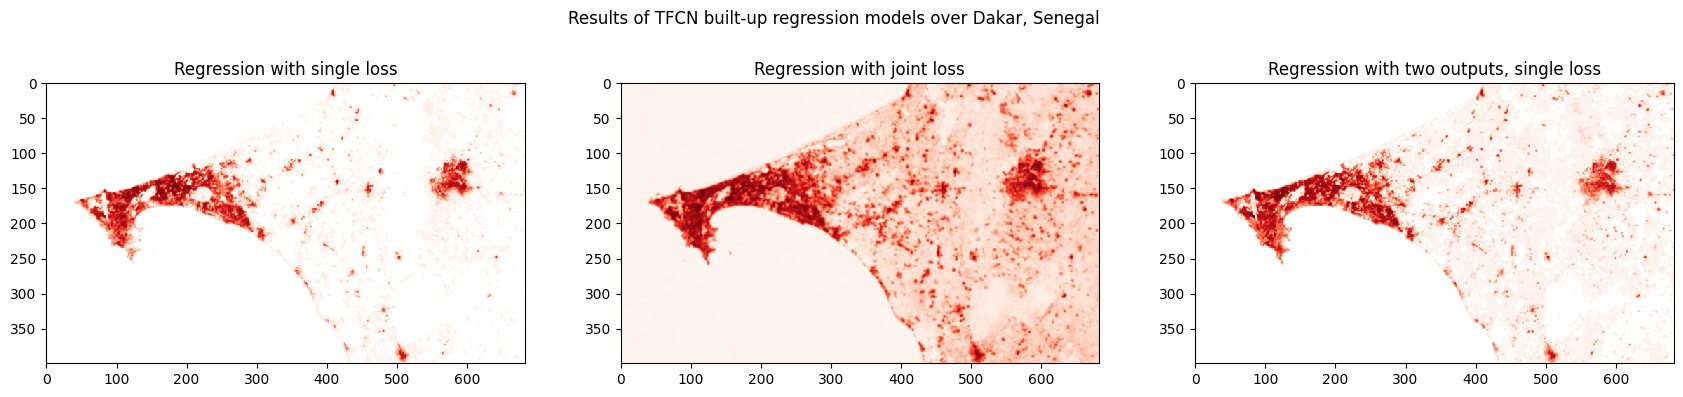

In [63]:
fig, axes = plt.subplots(figsize=(21, 7), ncols=3)
for idx, (ax, model) in enumerate(zip(axes.flatten(), ["single loss", "joint loss", "two outputs, single loss"])):
    ax.imshow(
        np.ma.masked_where(
            eopatch.data["tfcn"].squeeze(axis=(0))[..., idx] < 1.0e-3, eopatch.data["tfcn"].squeeze(axis=(0))[..., idx]
        ),
        interpolation="nearest",
        cmap=plt.cm.Reds,
    )
    ax.set_title(f"Regression with {model}")
fig.suptitle("Results of TFCN built-up regression models over Dakar, Senegal", y=0.8);